In [1]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
data_path = r"data"

In [3]:
def load_and_preprocess_images(dataset_dir, img_size=(224, 224)):
    images = []
    labels = []
    
    classes = os.listdir(dataset_dir)
    for class_name in classes:
        class_path = os.path.join(dataset_dir, class_name)
        class_images = os.listdir(class_path)
        
        for image_name in class_images:
            image_path = os.path.join(class_path, image_name)
            
            # Load image
            image = load_img(image_path, target_size=img_size)
            
            # Convert to array
            image_array = img_to_array(image)
            
            # Preprocess for Xception
            image_preprocessed = preprocess_input(image_array)
            
            images.append(image_preprocessed)
            labels.append(class_name)
    
    # Encode class labels
    class_encoder = LabelEncoder()
    labels_encoded = class_encoder.fit_transform(labels)
    
    return np.array(images), labels_encoded, class_encoder


In [4]:
X, y, label_encoder = load_and_preprocess_images(data_path)

In [5]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))  # Dynamically determine the number of classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [7]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-20]:  # Freeze layers
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom top layers
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Define the input shape for grayscale images
    layers.Resizing(224,224),  # Resize input images 
    layers.Conv2D(3, (1, 1)),  # Convert grayscale to RGB (3 channels)
    base_model,  # Add the base model (which contains the pre-trained layers)
    layers.GlobalAveragePooling2D(),  # Pooling layer to take the average across the output
    layers.Dense(256, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer with 50% rate
    layers.Dense(8, activation='softmax')  # Output layer (for binary classification task)
])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 3)    │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,388,092 (81.59 MB)

 Trainable params: 7,852,988 (29.96 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

In [8]:
# Compile the model
model.compile(optimizer = Adam(learning_rate=1e-4) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(X_train)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [11]:
# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.3497 - loss: 1.7692 - val_accuracy: 0.7559 - val_loss: 0.6863
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.8007 - loss: 0.6421 - val_accuracy: 0.8715 - val_loss: 0.3908
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.8385 - loss: 0.5157 - val_accuracy: 0.8844 - val_loss: 0.4053
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8822 - loss: 0.3674 - val_accuracy: 0.8908 - val_loss: 0.3609
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9089 - loss: 0.2849 - val_accuracy: 0.8779 - val_loss: 0.4324
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9373 - loss: 0.2107 - val_accuracy: 0.8587 - val_loss: 0.4893
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9274 - loss: 0.2213 - val_accuracy: 0.8887 - val_loss: 0.3926


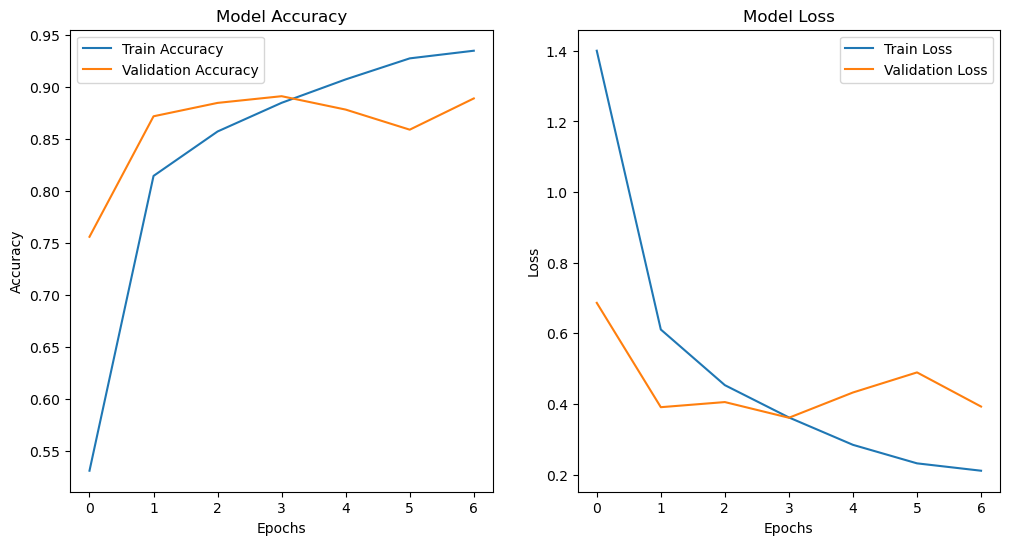

In [15]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
# Assuming you have the history object from model.fit()
train_accuracy = history.history['accuracy'][-1]  # Last epoch training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")


Training Accuracy: 0.9344337582588196
Validation Accuracy: 0.8886509537696838


In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


Test Accuracy: 0.9081196784973145
Test Loss: 0.2812190353870392


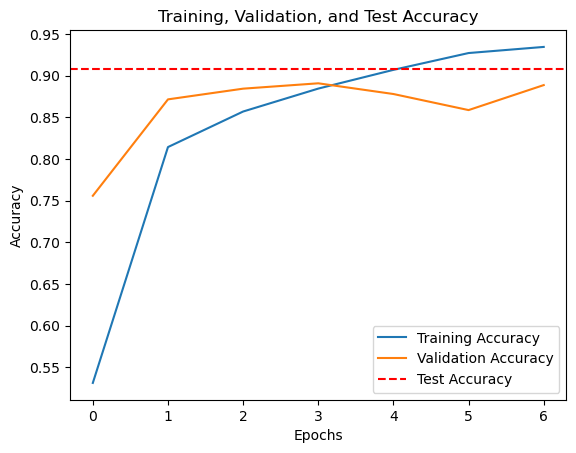

In [38]:

# Plot training, validation, and test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


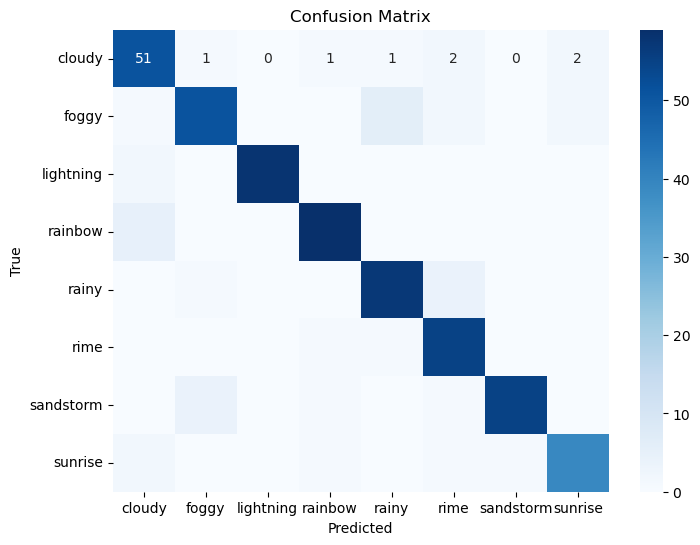

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the classes for the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Class names (decoded from the LabelEncoder)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report

# Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='weighted')  # or 'macro', 'micro'
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.9109
Recall: 0.9081
F1 Score: 0.9084


In [26]:
report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

      cloudy       0.84      0.88      0.86        58
       foggy       0.89      0.82      0.86        62
   lightning       1.00      0.97      0.98        60
     rainbow       0.94      0.92      0.93        64
       rainy       0.88      0.92      0.90        62
        rime       0.85      0.96      0.90        57
   sandstorm       0.98      0.90      0.94        61
     sunrise       0.91      0.89      0.90        44

    accuracy                           0.91       468
   macro avg       0.91      0.91      0.91       468
weighted avg       0.91      0.91      0.91       468



15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


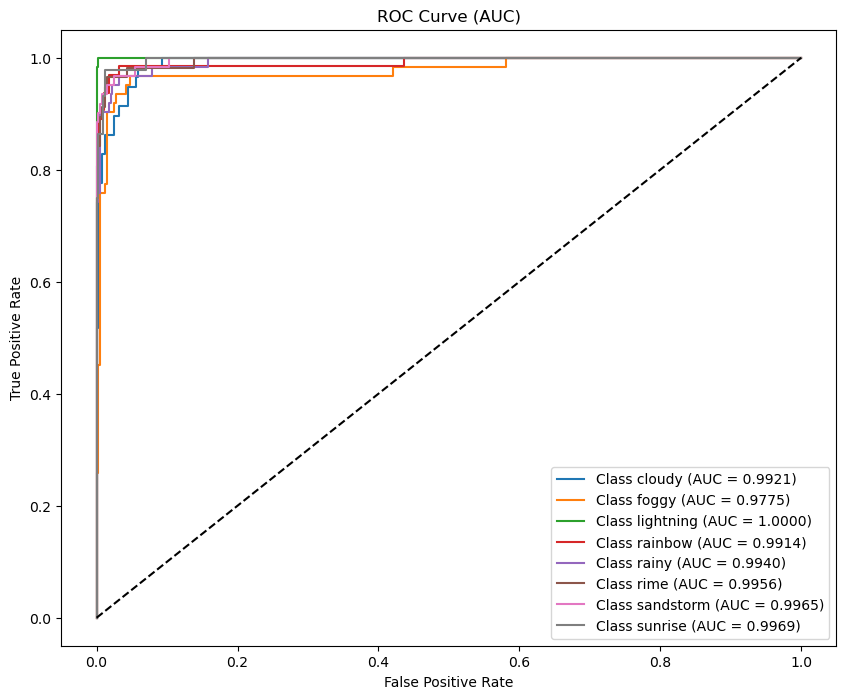

In [20]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Initialize plot
plt.figure(figsize=(10, 8))

# Compute ROC curve and AUC for each class
for i in range(num_classes):  # Iterate through each class
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC curve for each class
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

# Plot diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC)')
plt.legend(loc='lower right')
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


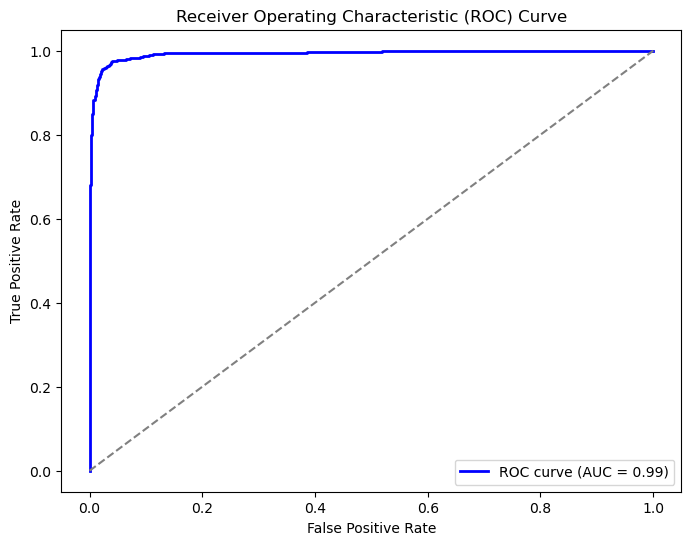

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3,4,5,6,7])  # Adjust classes if needed
y_pred_bin = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
